In [21]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Visualize Input Images**

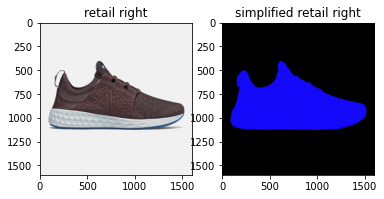

In [3]:
fig, ax = plt.subplots(1, 2)

retail_path = '/content/drive/My Drive/504_project/Stitching/right.jpg'
retail = cv2.imread(retail_path)/255
ax[0].imshow(retail, cmap="gray")
ax[0].set_title("retail right")

retail_simplified_path = '/content/drive/My Drive/504_project/Stitching/right_photoshoped_blue.jpg'
retail_simplified = plt.imread(retail_simplified_path)/255
ax[1].imshow(retail_simplified, cmap="gray")
ax[1].set_title("simplified retail right")

plt.show()

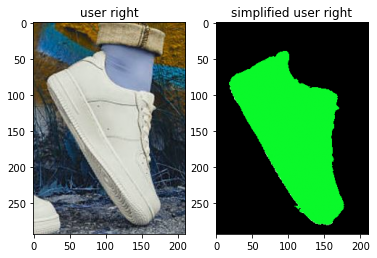

In [4]:
fig, ax = plt.subplots(1, 2)

user_path = '/content/drive/My Drive/504_project/Stitching/user_right.JPG'
user = cv2.imread(user_path)/255
ax[0].imshow(user, cmap="gray")
ax[0].set_title("user right")

user_simplified_path = '/content/drive/My Drive/504_project/Stitching/user_right_green.jpg'
user_simplified = plt.imread(user_simplified_path)/255
ax[1].imshow(user_simplified, cmap="gray")
ax[1].set_title("simplified user right")

plt.show()

#**PCA orientation matching**

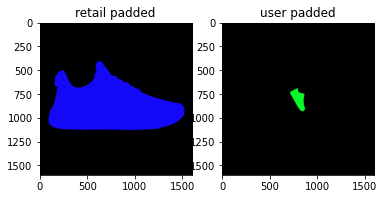

In [5]:
#make matching sizes
#cv2.copyMakeBorder Ref: https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
user_h, user_w, _ = user.shape
retail_h, retail_w, _ = retail.shape

height, width = max(user_w, retail_w), max(user_h, retail_h)

user_w_left = (width - user_w)//2
user_w_right = width - user_w - user_w_left
user_h_top = (height - user_h)//2
user_h_bottom = height - user_h - user_h_top
user_padded = cv2.copyMakeBorder(user_simplified,
                                user_h_top,user_h_bottom,user_w_left,user_w_right,
                                cv2.BORDER_CONSTANT,value=[0,0,0])

retail_w_left = (width - retail_w)//2
retail_w_right = width - retail_w - retail_w_left
retail_h_top = (height - retail_h)//2
retail_h_bottom = height - retail_h - retail_h_top
retail_padded = cv2.copyMakeBorder(retail_simplified,
                                retail_h_top,retail_h_bottom,retail_w_left,retail_w_right,
                                cv2.BORDER_CONSTANT,value=[0,0,0])

fig, ax = plt.subplots(1,2)
ax[0].imshow(retail_padded, cmap='gray')
ax[0].set_title("retail padded")
ax[1].imshow(user_padded, cmap='gray')
ax[1].set_title("user padded")
plt.show()

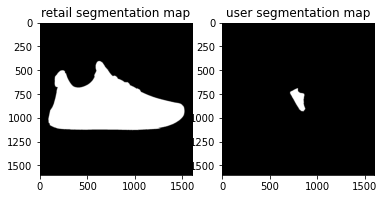

In [6]:
fig, ax = plt.subplots(1,2)

#retail photo segmentation map
retail_seg = retail_padded[:,:,0] != 0
ax[0].imshow(retail_seg, cmap='gray')
ax[0].set_title("retail segmentation map")

#user photo segmentation map
user_seg = user_padded[:,:,0] != 0
ax[1].imshow(user_seg, cmap='gray')
ax[1].set_title("user segmentation map")

plt.show()

In [7]:
def largest_eigvec(seg_map):
  #create 2 x N array
  Y, X = seg_map.nonzero() # (row# = Y) (col# = X)
  coords = np.zeros((2, len(X)))
  coords[0, :] = np.array(X)
  coords[1, :] = np.array(Y)
  avg = np.mean(coords, axis=1)
  coords = coords - avg.reshape(2, 1) #make it 0-mean

  u, s, vh = np.linalg.svd(coords, full_matrices=False)
  largest = np.argmax(s) #index of largest eigval
  largest_vec = u[largest, :] #largest eigval for covarianace matrix (row of U)

  return largest_vec

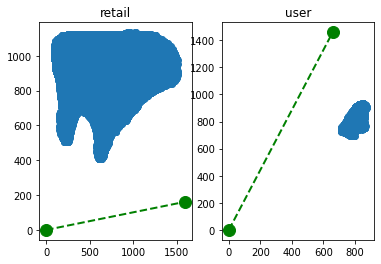

In [8]:
retail_eigvec = largest_eigvec(retail_seg)
user_eigvec = largest_eigvec(user_seg)

if np.all(retail_eigvec < 0):
  retail_eigvec *= -1
if np.all(user_eigvec < 0):
  user_eigvec *= -1

#visualize largest eigenvector
fig, ax = plt.subplots(1,2)

rows, cols = retail_seg.shape

Y, X = retail_seg.nonzero()
ax[0].scatter(X,Y)
ax[0].plot([retail_eigvec[0], retail_eigvec[0]*rows], [retail_eigvec[1], retail_eigvec[1]*cols], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax[0].set_title("retail")

Y, X = user_seg.nonzero()
ax[1].scatter(X,Y)
ax[1].plot([user_eigvec[0], user_eigvec[0]*rows], [user_eigvec[1], user_eigvec[1]*cols], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax[1].set_title("user")

plt.show()

In [9]:
#two different rotation is possible since we are matching a line to a line
#currently it assumes the shoes' bottom are both facing towards the bottom of the photo
def get_rotation_mat(eigvec, img):
  ax_vec = np.array([1,0])
  theta = np.arccos(np.dot(eigvec, ax_vec))
  rows, cols, c = img.shape
  direction = np.sign(eigvec[0])
  angle = direction*theta*180/np.pi
  user_M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
  return user_M, angle

In [10]:
def rotate_seg_map(seg_map, rot_M, is_homography=False):
  rows, cols = seg_map.shape
  seg_temp = np.zeros((rows, cols, 3))
  for i in range(c):
    seg_temp[:,:,i] = seg_map #create temporary c channel segmentation map
  if is_homography:
    #transform then remove duplciate
    seg_temp = cv2.warpPerspective(seg_temp, rot_M, (cols, rows))[:,:,0]
  else:
    #transform then remove duplciate
    seg_temp = cv2.warpAffine(seg_temp, rot_M, (cols, rows))[:,:,0]
  return seg_temp

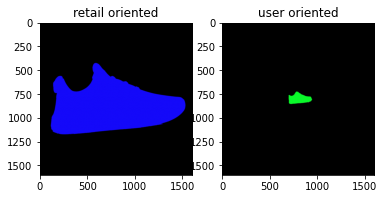

In [11]:
retail_M, retail_angle = get_rotation_mat(retail_eigvec, retail_padded)
user_M, user_angle = get_rotation_mat(user_eigvec, user_padded)

fig, ax = plt.subplots(1,2)

rows, cols, c = retail_padded.shape
retail_oriented = cv2.warpAffine(retail_padded, retail_M, (cols, rows))
retail_seg_oriented = rotate_seg_map(retail_seg, retail_M)
ax[0].imshow(retail_oriented, cmap="gray")
ax[0].set_title("retail oriented")

rows, cols, c = user_padded.shape
user_oriented = cv2.warpAffine(user_padded, user_M, (cols, rows))
user_seg_oriented = rotate_seg_map(user_seg, user_M)
ax[1].imshow(user_oriented, cmap="gray")
ax[1].set_title("user oriented")

plt.show()

#**Least Squares Matching**

In [12]:
def find_left_right(oriented_seg_map):
  Y, X = oriented_seg_map.nonzero()
  leftmost = np.min(X)
  rightmost = np.max(X)
  return leftmost, rightmost

In [13]:
def contour_slices(oriented_seg_map, num_slices = 10):
  leftmost, rightmost = find_left_right(oriented_seg_map)
  interval = (rightmost-leftmost)/(num_slices+1) #double
  X = np.zeros(num_slices*2)
  Y = np.zeros(num_slices*2)
  for i in range(num_slices):
    slice_pos = int(leftmost + interval*(i+1)) #integer value
    y_vals = oriented_seg_map[:, slice_pos].nonzero()
    X[i*2:i*2+2] = slice_pos
    Y[i*2] = np.min(y_vals) #lowest contour intersection
    Y[i*2+1] = np.max(y_vals) #highest contour intersection
  return X, Y

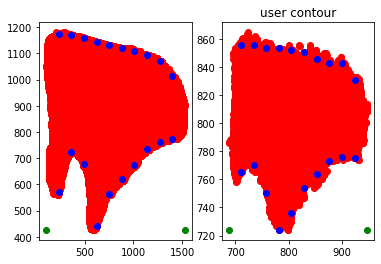

In [14]:
retail_contour_X, retail_contour_Y = contour_slices(retail_seg_oriented)
user_contour_X, user_contour_Y = contour_slices(user_seg_oriented)

#visualize user contour
fig, ax = plt.subplots(1, 2)

Y, X = retail_seg_oriented.nonzero()
ax[0].scatter(X, Y, color='red')
ax[0].scatter(retail_contour_X, retail_contour_Y, color='blue')
leftmost, rightmost = find_left_right(retail_seg_oriented)
ax[0].scatter([leftmost, rightmost], [np.min(Y),np.min(Y)], color='green', label="leftmost, rightmost")
ax[1].set_title("retail contour")

Y, X = user_seg_oriented.nonzero()
ax[1].scatter(X, Y, color='red')
ax[1].scatter(user_contour_X, user_contour_Y, color='blue')
leftmost, rightmost = find_left_right(user_seg_oriented)
ax[1].scatter([leftmost, rightmost], [np.min(Y),np.min(Y)], color='green')
ax[1].set_title("user contour")

plt.show()

In [15]:
#NOT USED
#Ordinary Least squares for retail --> user, min||Ax-b||^2
num_slices = len(retail_contour_X)
A = np.zeros((num_slices*2, 3))
b = np.zeros(num_slices*2)
for i in range(num_slices):
  x, y = retail_contour_X[i], retail_contour_Y[i]
  A[i*2, :] = np.array([x,1,0])
  A[i*2+1, :] = np.array([y,0,1])
  b[i*2] = user_contour_X[i]
  b[i*2+1] = user_contour_Y[i]

x = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), b)
print(x) #scale, tx, ty
print(np.matmul(A,x)-b)


[1.84460941e-01 6.66295411e+02 6.40125376e+02]
[ -0.98734589 -19.73188789  -0.98734589   0.68252059  -1.19188448
   3.859558    -1.19188448  -0.05532317  -0.39642306  15.18989376
  -0.39642306  -0.08439353  -0.60096165  -2.34288836  -0.60096165
  -2.85130764   0.19449976   8.16134647   0.19449976  -2.880378
  -0.19449976   0.30669823  -0.19449976  -4.27837023   0.60096165
   0.26758906   0.60096165  -1.30744059   0.39642306   2.51970647
   0.39642306  -0.88989376   1.19188448   4.50015188   1.19188448
  -5.50141729   0.98734589   8.08260506   0.98734589  -3.64676906]


In [16]:
#cv2.estimateAffinePartial2D Ref: https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#gad767faff73e9cbd8b9d92b955b50062d
src = np.vstack((retail_contour_X, retail_contour_Y)).T
dst = np.vstack((user_contour_X, user_contour_Y)).T
#affine_m, pts = cv2.estimateAffinePartial2D(src, dst)
#affine_m, pts = cv2.estimateAffine2D(src, dst)
homography_m, pts = cv2.findHomography(src, dst)

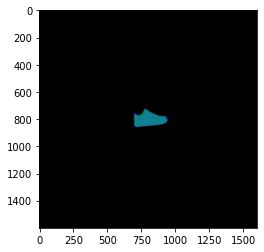

In [17]:
"""
#getting the scale and angle for similarity transform
scos = affine_m[0,0]
ssin = affine_m[1,0]

theta = np.arctan(ssin/scos)
angle = theta * 180 / np.pi
scale = np.sqrt(scos**2 + ssin **2)
print(angle, scale)
"""

rows, cols, c = retail_oriented.shape
#retail_transformed = cv2.warpAffine(retail_oriented, affine_m, (cols, rows))
#retail_seg_transformed = rotate_seg_map(retail_seg_oriented, affine_m)
retail_transformed = cv2.warpPerspective(retail_oriented, homography_m, (cols, rows))
retail_seg_transformed = rotate_seg_map(retail_seg_oriented, homography_m, True)

overlay = retail_transformed.copy()
overlay = overlay/2 + user_oriented/2
plt.imshow(overlay)

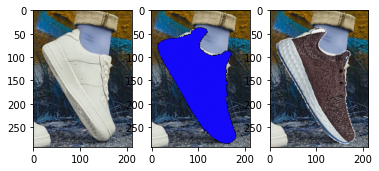

In [18]:
#mask using user segmentation map (optional)

#rotate back to user's original orientation
rows, cols = retail_seg_oriented.shape
reverse_rot_M = cv2.getRotationMatrix2D((rows/2,cols/2),-user_angle, 1) #Note: negative angle
retail_complete = cv2.warpAffine(retail_transformed, reverse_rot_M, (cols,rows))
retail_seg_complete = rotate_seg_map(retail_seg_transformed, reverse_rot_M)

#crop out padding
retail_complete = retail_complete[user_h_top:user_h_top+user_h, user_w_left:user_w_left+user_w, :]
retail_seg_complete = retail_seg_complete[user_h_top:user_h_top+user_h, user_w_left:user_w_left+user_w] != 0
#retail_seg_complete need != 0 because not all values are 0/1's because of rotation

#paste it back to user photo
_, _, c = user.shape
user_complete = user.copy()
for i in range(c):
  user_complete[:,:,i][retail_seg_complete] = retail_complete[:,:,i][retail_seg_complete]


#if we were to apply this to the orignal retail image
original = retail.copy()
original_padded = cv2.copyMakeBorder(original,
                                retail_h_top,retail_h_bottom,retail_w_left,retail_w_right,
                                cv2.BORDER_CONSTANT,value=[0,0,0])
rows, cols, c = original.shape
original_oriented = cv2.warpAffine(original_padded, retail_M, (cols, rows))
#original_transformed = cv2.warpAffine(original_oriented, affine_m, (cols, rows))
original_transformed = cv2.warpPerspective(original_oriented, homography_m, (cols, rows))
original_complete = cv2.warpAffine(original_transformed, reverse_rot_M, (cols,rows))
original_complete = original_complete[user_h_top:user_h_top+user_h, user_w_left:user_w_left+user_w, :]
user2_complete = user.copy()
for i in range(c):
  user2_complete[:,:,i][retail_seg_complete] = original_complete[:,:,i][retail_seg_complete]

#visualize final stitching
fig, ax = plt.subplots(1,3)
ax[0].imshow(user)
ax[1].imshow(user_complete)
ax[2].imshow(user2_complete)

In [19]:
#TO DO:
# have matching between the user photo and multiple retail photos (right, left, top)
# analyze their least squares error to pick the best stitching